# Predict Nighttime Light Intensities from Daytime Light 

First pass.  
Current Goal: Use CNN to extract features from daytime lights (Landsat) data and predict levels of nighhtime light intensities (VIIRS).
***
General Steps:
1. Import the data
2. Feature creation
3. Build the Neural Net
4. Evaluate the Neural Net

In [1]:
import os
import pandas as pd
import geopandas as gpd
import rasterio

import getpass

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# Set directory
os.chdir("/Users/nguyenluong/wb_internship/Data/satellite_raw")

In [4]:
# Rob's code
if getpass.getuser() == 'robmarty':
    project_file_path = '/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites'
    
filepath_night = project_file_path + "/Data/VIIRS/RawData/VIIRS Annual/pak_viirs_median_2012.tif"
data_night = rasterio.open(filepath_night)
array_night = data_night.read()
np.nanmean(array_night)

array_night_flat = array_night.flatten()
array_night_flat_nona = array_night_flat[ ~np.isnan(array_night_flat) ]
plt.hist(array_night_flat_nona)

# 1. Import and Prep Data

## 1a. Load and Prep Nighttime Lights Data 

### Load VIIRS Geojson

In [2]:
# Load nighttime VIIRS data (geojson)
viirs_gdf = gpd.read_file('VIIRS/VIIRS Annual/viirs_annual_polygon.geojson')
viirs_gdf.head(2)

,median_rad_2012,median_rad_2013,median_rad_2014,median_rad_2015,median_rad_2016,median_rad_2017,median_rad_2018,id,tile_id,geometry
0,0.121902,0.217595,0.179258,0.213304,0.148595,0.352908,0.34,1,42.0,"POLYGON ((74.66347 37.06224, 74.67021 37.06224..."
1,0.204110,0.223363,0.207353,0.283295,0.156230,0.375000,0.36,2,42.0,"POLYGON ((74.67021 37.06224, 74.67695 37.06224..."


In [14]:
# Inspecting VIIRS geojson
print('Total number of obs: {}'.format(len(viirs_gdf)))

nan_tile = viirs_gdf[np.isnan(viirs_gdf['tile_id'])]
print('Number of obs with NaN for tile_id: {}'.format(len(nan_tile)))

Total number of obs: 1814237
Number of obs with NaN for tile_id: 1350


In [46]:
# Inspecting polygon areas
copy = viirs_gdf.copy()
copy['area'] = copy['geometry'].area

<ipython-input-46-2f04319d78b6>:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  copy['area'] = copy['geometry'].area


In [47]:
copy['area'].value_counts()

0.000045    669397
0.000045    596279
0.000045    196763
0.000045    136444
0.000045    118308
0.000045     65386
0.000045     31399
0.000045       172
0.000045        89
Name: area, dtype: int64

### Transform nighttime lights

Transform to lessen heavily skewed distribution. For now, **limit to only 2014 data**.   
***
Options tried here:
- natural log
- square root
- box-cox

doc: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html#r742a88cfa144-1

In [48]:
from sklearn.preprocessing import power_transform

# Do log(x + 1) to have fully defined domain since data has x = 0
viirs_gdf['log_median_rad_2014'] = np.log(viirs_gdf['median_rad_2014'] + 1)
log_rad = np.log(viirs_gdf['median_rad_2014'] + 1).to_numpy()

sqrt_rad = np.sqrt(viirs_gdf['median_rad_2014']).to_numpy()

# Do box-cox with (x + 1) because needs strictly positive values 
bc_rad = power_transform((viirs_gdf['median_rad_2014'] + 1).to_numpy().reshape(-1, 1), method='box-cox')

Explore the distributions of variable transformations to decide which to go forward with.

Summary of log
DescribeResult(nobs=1814237, minmax=(0.0, 7.003241113635235), mean=0.20576721970884848, variance=0.062333206493509284, skewness=6.602233458742071, kurtosis=63.58599491384153)

Summary of square-root
DescribeResult(nobs=1814237, minmax=(0.0, 33.154083267445166), mean=0.45985096480354326, variance=0.10546258282824325, skewness=10.262868875497135, kurtosis=252.55956265564947)

Summary of box-cox
DescribeResult(nobs=1814237, minmax=(-3.0815043715438386, 2.3062005044008833), mean=8.316728796961411e-16, variance=1.0000005511962058, skewness=0.5906939197104081, kurtosis=-0.34560818439899155)



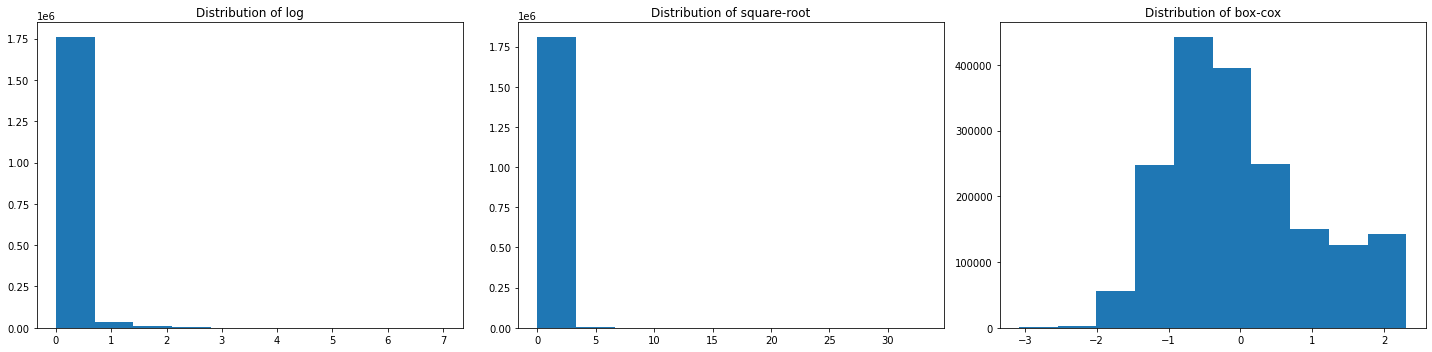

In [49]:
from scipy import stats

def explore_distrib(vars_dict):
    fig, ax = plt.subplots(figsize=(20,5), ncols=len(vars_dict.values()))
    i = 0
    for var_name, array in vars_dict.items():
        if len(array.shape) > 1:
            array = array.flatten()
        print('Summary of ' + var_name)
        print(stats.describe(array))
        print()
        ax[i].hist(array);
        ax[i].set_title('Distribution of ' + var_name);
        i += 1
    plt.tight_layout()
    plt.show()

vars_dict = {'log': log_rad, 'square-root': sqrt_rad, 'box-cox': bc_rad}
explore_distrib(vars_dict)

### Choose Transformation and Bin NLT

I feel like it makes sense to feel values positive for interpretation of radiance. Log has lowered skewness and smaller range of values. So, I will discretize log median radiance for 2014 with k-means clustering.

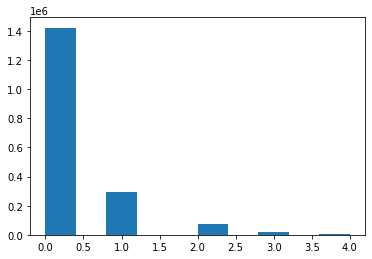

In [50]:
from sklearn.preprocessing import KBinsDiscretizer
# Reshape array to be a column rather than a row
log_rad = viirs_gdf['log_median_rad_2014'].to_numpy().reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
viirs_gdf['log_binned'] = discretizer.fit_transform(log_rad)
plt.hist(viirs_gdf['log_binned']);

In [51]:
# Nighttime lights is bucketed into 5 categories
print('Bins')
print(viirs_gdf['log_binned'].value_counts())
print('Bin edges: {}'.format(discretizer.bin_edges_[0]))

Bins
0.0    1422278
1.0     294299
2.0      72758
3.0      18364
4.0       6538
Name: log_binned, dtype: int64
Bin edges: [0.         0.2270032  0.51066626 1.08064124 2.13831268 7.00324111]


## 1b. Create Random Sample
***
For now, sample for 15 observations for each NTL bin.

In [52]:
def sample_by_NTL(df, NTL_col, n):
    '''
    Create a dataframe that contains n samples from each NTL bin.
    '''
    rv = pd.DataFrame()
    for x in df[NTL_col].unique():
        bin_df = df[df[NTL_col] == x]
        sample_df = bin_df.sample(n=n, random_state=1)
        rv = rv.append(sample_df)
    return rv
        
df_2014 = viirs_gdf[['tile_id', 'median_rad_2014', 'log_median_rad_2014', 'log_binned', 'geometry']]
NTL_df = sample_by_NTL(df_2014, 'log_binned', 15)
print(NTL_df['log_binned'].value_counts())
NTL_df.head()

4.0    15
3.0    15
2.0    15
1.0    15
0.0    15
Name: log_binned, dtype: int64


,tile_id,median_rad_2014,log_median_rad_2014,log_binned,geometry
1673685,7.0,0.091575,0.087621,0.0,"POLYGON ((64.69891 25.48745, 64.70565 25.48745..."
859908,21.0,0.122107,0.115208,0.0,"POLYGON ((67.71725 29.73199, 67.72399 29.73199..."
618665,25.0,0.127695,0.120176,0.0,"POLYGON ((66.80771 31.15357, 66.81445 31.15357..."
1002658,22.0,0.196145,0.179104,0.0,"POLYGON ((70.47957 29.11889, 70.48631 29.11889..."
1467539,8.0,0.079857,0.076829,0.0,"POLYGON ((66.90203 26.61259, 66.90877 26.61259..."


In [53]:
# Remove observations with NaN as tile_id
NTL_df = NTL_df[ ~ np.isnan(NTL_df['tile_id'])]
len(NTL_df)

75

## 1c. Get DLT corresponding sampled NTL

In [54]:
from rasterio.mask import mask

def format_coords(Polygon):
    '''
    Format coordinates of a Polygon to what rasterio likes for masking / cropping.
    '''
    coords = list(Polygon.exterior.coords)
    dictionary = {'type': 'Polygon'}
    dictionary['coordinates'] = [[list(tup) for tup in coords]]
    return [dictionary]

def crop(raw_DTL, polygon):
    '''
    Crops DLT according to VIIRS polygon.
    '''
    shapes = format_coords(polygon)
    out_img, out_transform = mask(raw_DTL, shapes=shapes, crop=True)
    return out_img
    
def get_DTL(row, directory):
    '''
    For a given VIIRS observation, grab and crop corresponding DLT data.
    
    Returns: 
        all_bands: (list) list of 7 arrays, each array is 3D
    '''
    all_bands = []
    bands = [*range(1,8)]
    for b in bands:
        tile = row['tile_id']
        polygon = row['geometry']
        filename = ''.join(['l8_2014_tile', str(int(tile)), '_b', str(b), '.tif'])
        filepath = os.path.join(directory, filename)
        raw_DTL = rasterio.open(filepath)
        cropped_DTL = crop(raw_DTL, polygon)
        all_bands.append(cropped_DTL)
    return all_bands

def create_DLT_array(NTL_df, source='Landsat', year='New_2014'):
    '''
    Gets DTL images, crops them, create arrays representing DLT and NLT to become features and targets respectively.
    
    Returns: 
        DLT: (5D np.array)
    '''
    rv = []
    df = NTL_df.copy()
    directory = os.path.join(source, year)
    for index, row in df.iterrows():
        DTL = get_DTL(row, directory)
        rv.append(DTL)
    return np.stack(rv)

In [55]:
# Creating DTL array and defining NTL array
DTL = create_DLT_array(NTL_df)
NTL = NTL_df['log_binned'].to_numpy()

print('DLT shape: {}'.format(DTL.shape))
print('NLT shape: {}'.format(NTL.shape ))

DLT shape: (75, 7, 1, 25, 26)
NLT shape: (75,)


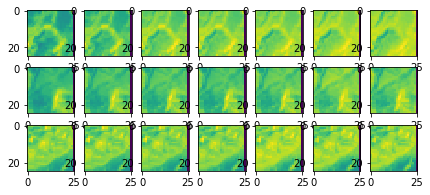

In [56]:
# Visualizing bands for a few DTL images as a visual check
to_plot = DTL[0:3]
num_images = to_plot.shape[0]
num_bands = to_plot.shape[1]

f, ax = plt.subplots(figsize=(num_bands, num_images), nrows=num_images, ncols=num_bands)
for i in range(0, num_images):
    for j in range(0, num_bands):
        ax[i, j].imshow(to_plot[i][j][0], origin='upper', interpolation='nearest')

# Reshaping and Normalizing Features and Targets
Reshape the data into an array of 3D tensors and normalize each element.

In [57]:
def prep_dataset(X, Y, height, width, channels):
    # Reshape data to be 4D rather than 5D
    X = X.reshape((X.shape[0], height, width, channels))
    # One-hot encode targets
    Y = to_categorical(Y)
    return X, Y

def normalize(X):
    # Convert from ints to floats and normalize to 0-1
    return X.astype('float32') / 255.0

# Build the CNN

In [58]:
def define_model(height, width, channels, num_classes):
    # Define layers
    model = Sequential()
    model.add(Conv2D(filters=64, 
                     kernel_size=(5, 5), 
                     activation='relu', 
                     input_shape=(height, width, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    print('Model has been defined. Model summary below.')
    model.summary()
    
    return model

# Evaluate the CNN

In [59]:
def evaluate_model(model, trainX, trainY, testX, testY):
    # Fit model
    history = model.fit(trainX, trainY, 
                        epochs=20, batch_size=5, 
                        validation_data=(testX, testY), verbose=True)
    print('Model has been fit.')
    
    # Evaluate model
    loss, accuracy = model.evaluate(testX, testY, verbose=False)
    print('Model has been evaluted.')
    print('Accuracy: {:.4f}'.format(accuracy))


def evaluate_with_crossval(model, dataX, dataY, k=2):
    # Define k-fold cross-val
    kfold = KFold(k, shuffle=True, random_state=1)
    print('Entering cross validation.')
    
    # Loop through folds
    for train_idx, test_idx in kfold.split(dataX):
        # Select subsets for training and testing
        trainX, trainY, testX, testY = dataX[train_idx], dataY[train_idx], dataX[test_idx], dataY[test_idx]
        print('Subsets have been selected.')
        # Pass to evaluate_model
        evaluate_model(model, trainX, trainY, testX, testY)

# Run the CNN

In [60]:
def go(DLT, NTL): 
    '''
    Runs CNN given a 5D array representing DTL (features) and a 1D array representing NTL (targets).
    '''
    # Split into training and testing data
    raw_trainX, raw_testX, raw_trainY, raw_testY = train_test_split(DTL, NTL, 
                                                                    test_size=0.2, 
                                                                    random_state=1)
    # Define image characteristics
    channels = 7
    height = 25
    width = 26
    num_classes = 5
    
    # Prep both training and testing data
    trainX, trainY = prep_dataset(raw_trainX, raw_trainY, height, width, channels)
    testX, testY = prep_dataset(raw_testX, raw_testY, height, width, channels)
    
    # Prep pixel data
    trainX, testX = normalize(trainX), normalize(testX)

    # Define and evaluate model
    model = define_model(height, width, channels, num_classes)
    evaluate_model(model, trainX, trainY, testX, testY)
    #evaluate_with_crossval(model, trainX, trainY)

In [61]:
go(DTL, NTL)

Model has been defined. Model summary below.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 22, 64)        11264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7040)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               704100    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 715,869
Trainable params: 715,869
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
12/12 [==============================] - 1s 91ms/step - loss